# Identification of polluted samples in a dataset using covariance analysis

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### $\mathbf{Problem \ Statement}$

### The attached file, 'polluted_data.csv', contains the following data:

### A time series of intraday price values for an asset was split into half-hour intervals for a total of 1709 intervals. Therefore, there are 1709 lines in this file, one for each half-hour interval. Each line begins with the count of the corresponding half-hour

### The data was constructed as follows for each half hour interval $t$ :-  

#### Suppose that $p(t, k)$ denotes the price of the asset in minute $k$ of half-hour $t$.  Here $k = 0,1,\ldots, 29$.  

#### The data in position $k+1$ of line $t$ of the file equals $p(t,k) - p(t,0)$, i.e. the change in price between minute $k$ and minute $0$.

### EXCEPT that:
#### The data was <font color = "red">polluted</font> in a <font color = "red">significant and correlated</font> manner during a certain <font color = "red"> interval $[t_1, t_2]$ </font> of half-hours.

#### Your task is to identify this interval $[t_1, t_2]$ as closely as possible, using <font color = "red">covariance analysis techniques</font>.

#### Please note that we are not interested in small, random noise.  We are looking for a large change in the covariance structure.

In [3]:
filename = 'polluted_data.csv'
f = open(filename,'r')
csvf = csv.reader(f)
polluteddeltalist = list(csvf)
f.close()
plist = np.array(polluteddeltalist)
polluteddata = plist.astype(float)
print(np.shape(polluteddata))

(1709, 31)


In [4]:
for t in range(3):
    print('half-hour',t, '; data:',polluteddata[t,:])

half-hour 0 ; data: [  0.     0.    -3.    -8.26 -10.55  -8.56 -18.08 -12.67 -14.29 -16.08
 -20.04 -15.81 -14.56 -17.34 -20.14 -15.96 -14.3  -15.82 -15.07 -12.39
 -20.65 -27.58 -31.51 -27.53 -25.24 -25.32 -24.44 -28.04 -30.94 -29.57
 -27.56]
half-hour 1 ; data: [  1.     0.     0.12  -0.41  -2.56   0.15  -1.65  -5.14  -5.09  -8.06
  -9.05 -14.9  -18.27 -16.18 -15.42 -13.8  -12.89 -12.87 -10.18 -12.7
  -9.21  -6.65  -5.43  -6.13  -3.42  -4.48  -4.85  -4.47  -4.68  -2.1
  -0.28]
half-hour 2 ; data: [  2.     0.    -2.8   -3.46  -5.8   -3.86  -2.6   -5.3   -4.81  -3.3
  -0.28   1.33   0.68   2.3    1.65  -9.32 -11.74 -11.49 -19.37 -11.8
 -10.87 -12.74 -13.02 -15.99 -14.15 -14.92 -16.8  -16.88 -19.53 -25.3
 -19.6 ]


In [5]:
polluteddataframe = pd.DataFrame(polluteddata)
polluteddataframe = polluteddataframe.drop(0, axis=1) # Drop the first column - indices - 0, 1, 2 ....
polluteddata_arr = np.array(polluteddataframe)

In [6]:
polluteddata_arr.shape

(1709, 30)

### First, we try to observe how the covariances among the 30 minute intervals changes as more and more intervals are added

We try to visualize the data as one with 30 dimensions (30 features)
\
\
We start with 100 samples (first 100 intervals)
\
\
Then we increase this number of samples by 100 on each iteration and try to figure out the point from which noise is added - by observing the visualization of the covariance matrix

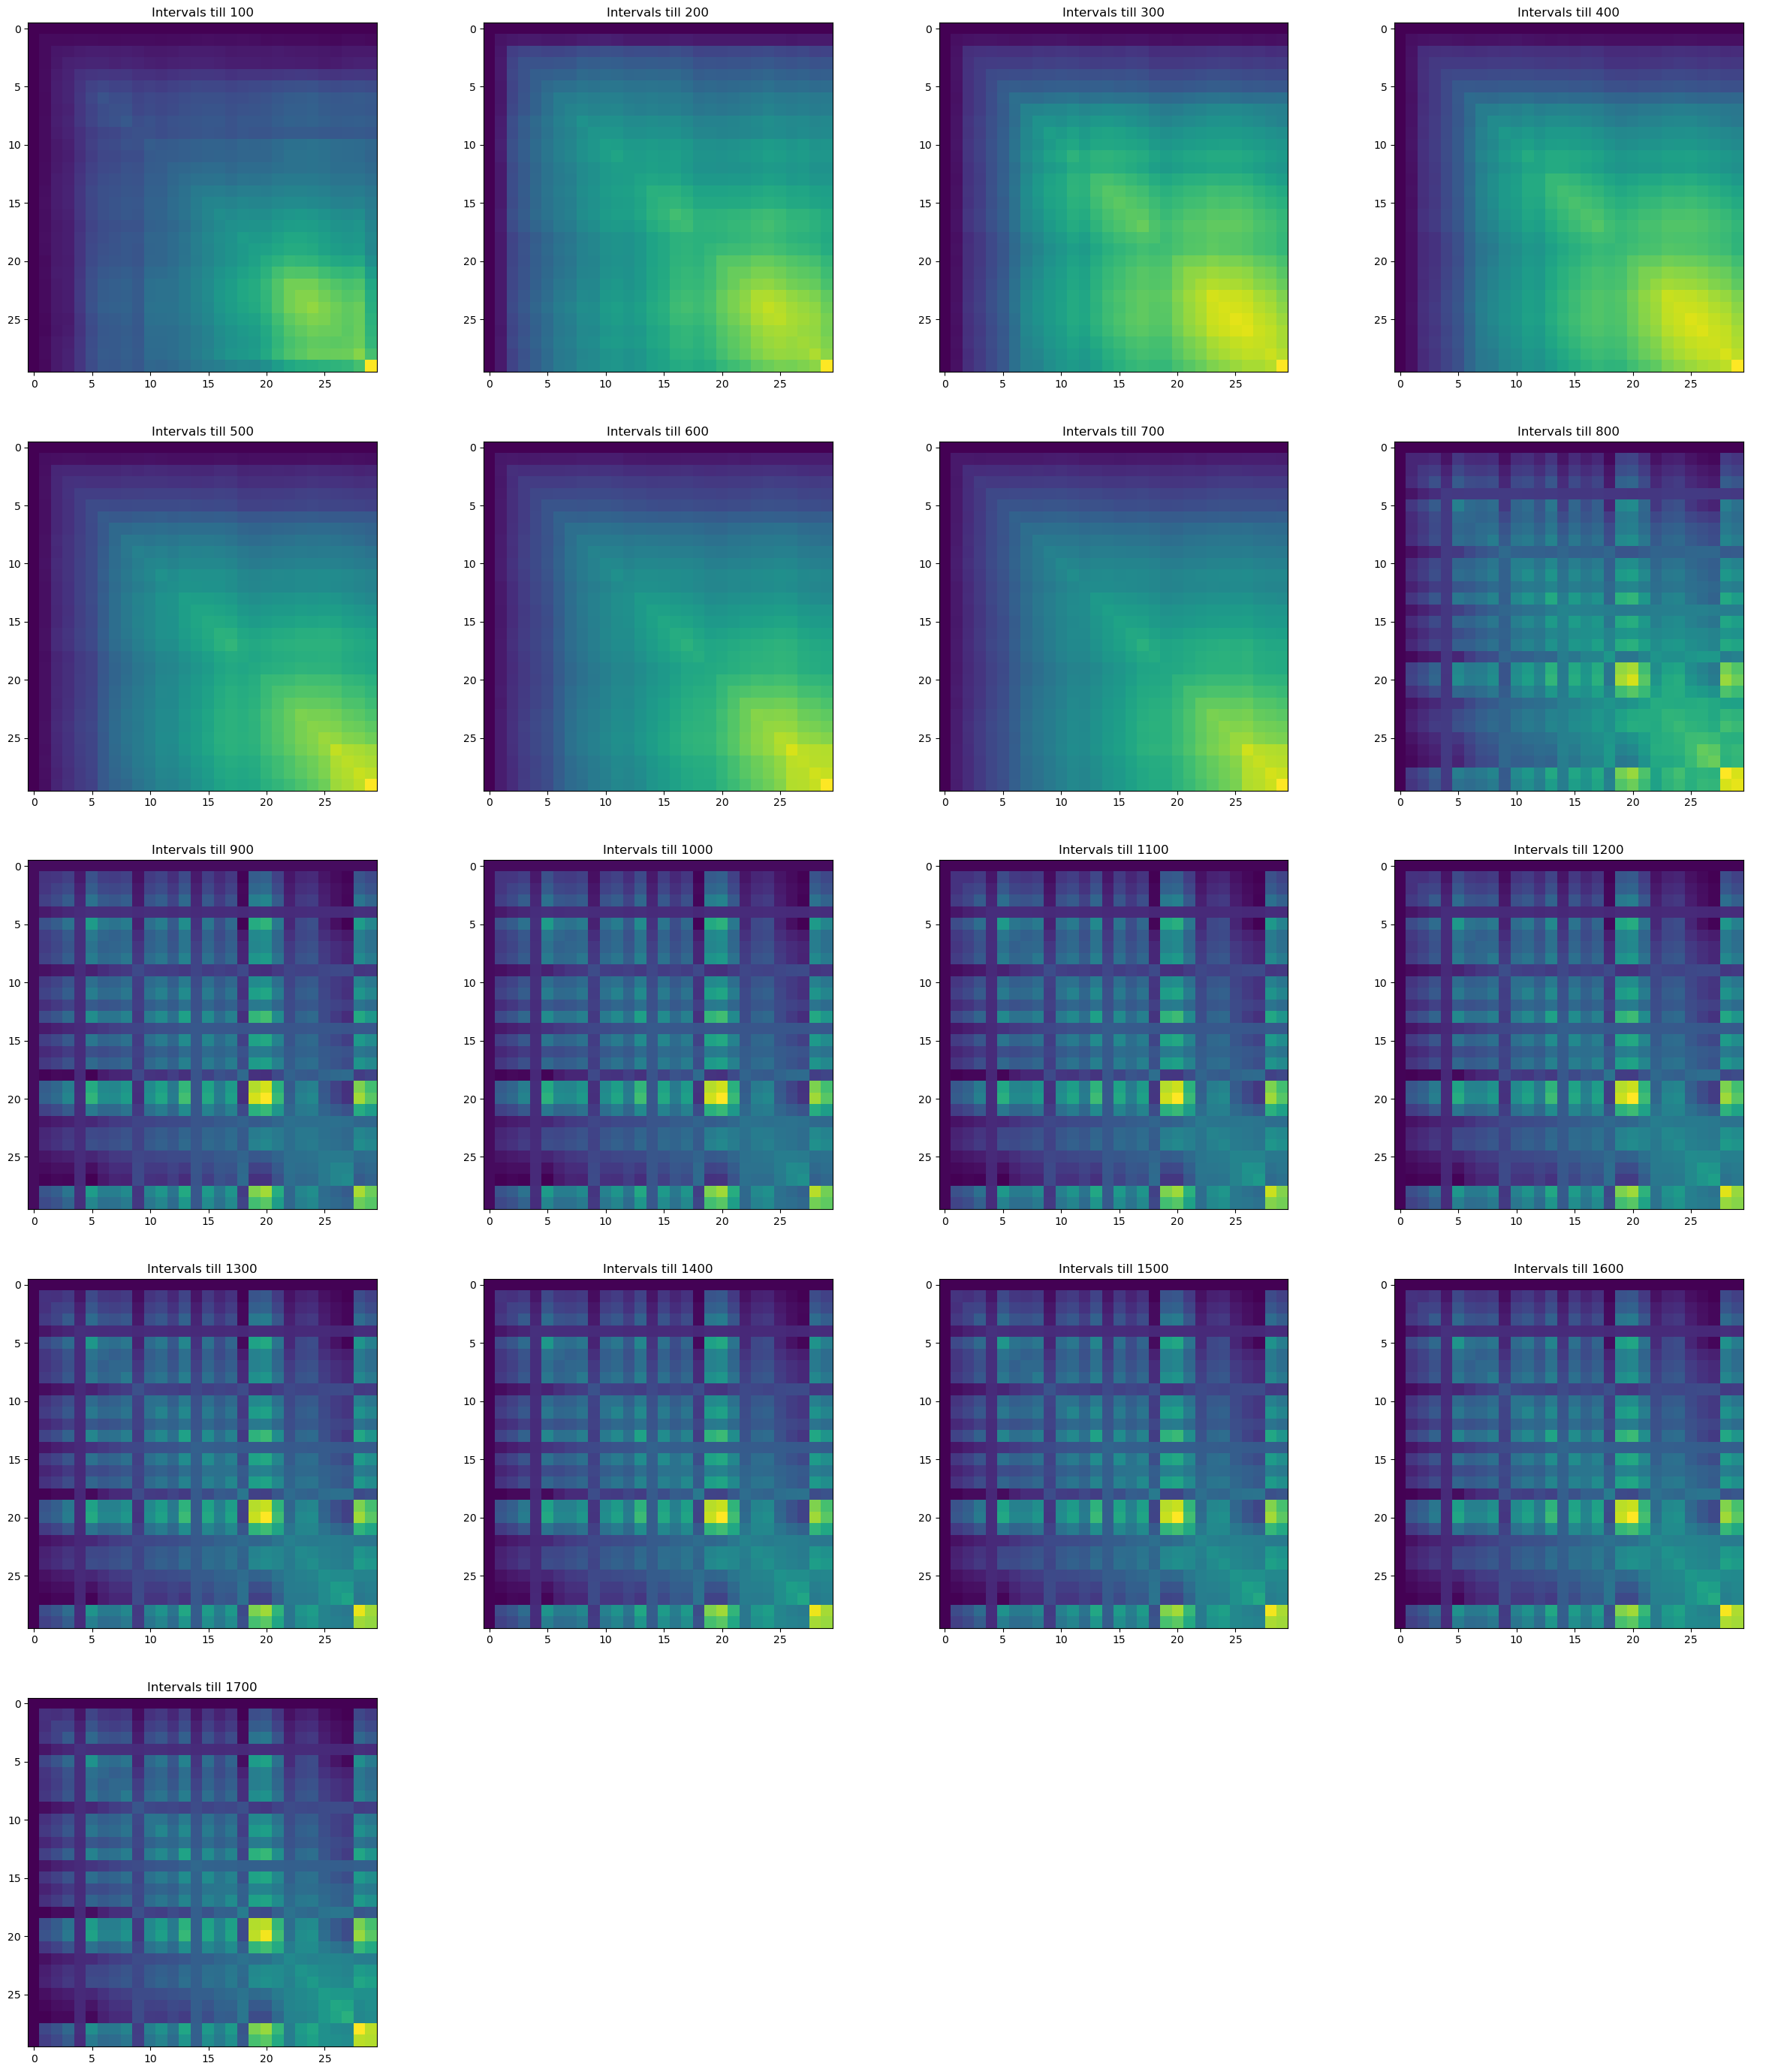

In [7]:
# Sequentially adding 100 rows on each iteration and re-computing the covariance matrix 

fig, axes = plt.subplots(5, 4, figsize=(30,35))

for i in range(100, len(polluteddata_arr), 100):

    covmat = np.cov(polluteddata_arr[:i], rowvar=False)
    
    ax = axes[ i//401, (i//101)%4 ]
    ax.imshow( covmat)
    ax.set_title(f'Intervals till {i}')

# Remove empty subplots
for i in range(17, len(axes.flat)):
    axes.flat[i].axis('off')

From the plots above, we can see that there is some significant irregularity when we add intervals after 700
\
\
The plots are relatively regular till we add 700 intervals ... after we add the intervals from 700 to 800 ... the start to get irregular
\
\
Hence, we can say that the lower bound for $t_1$ is 700

### Finding the upper bound for $t_2$ by iterating in reverse

Now, we start with the last 100 rows, and keep adding 100 rows on each iteration
\
\
As soon as we encounter the upper bound of the interval at which noise has been added i.e. $t_2$, we should see a significant irregularity in the plots

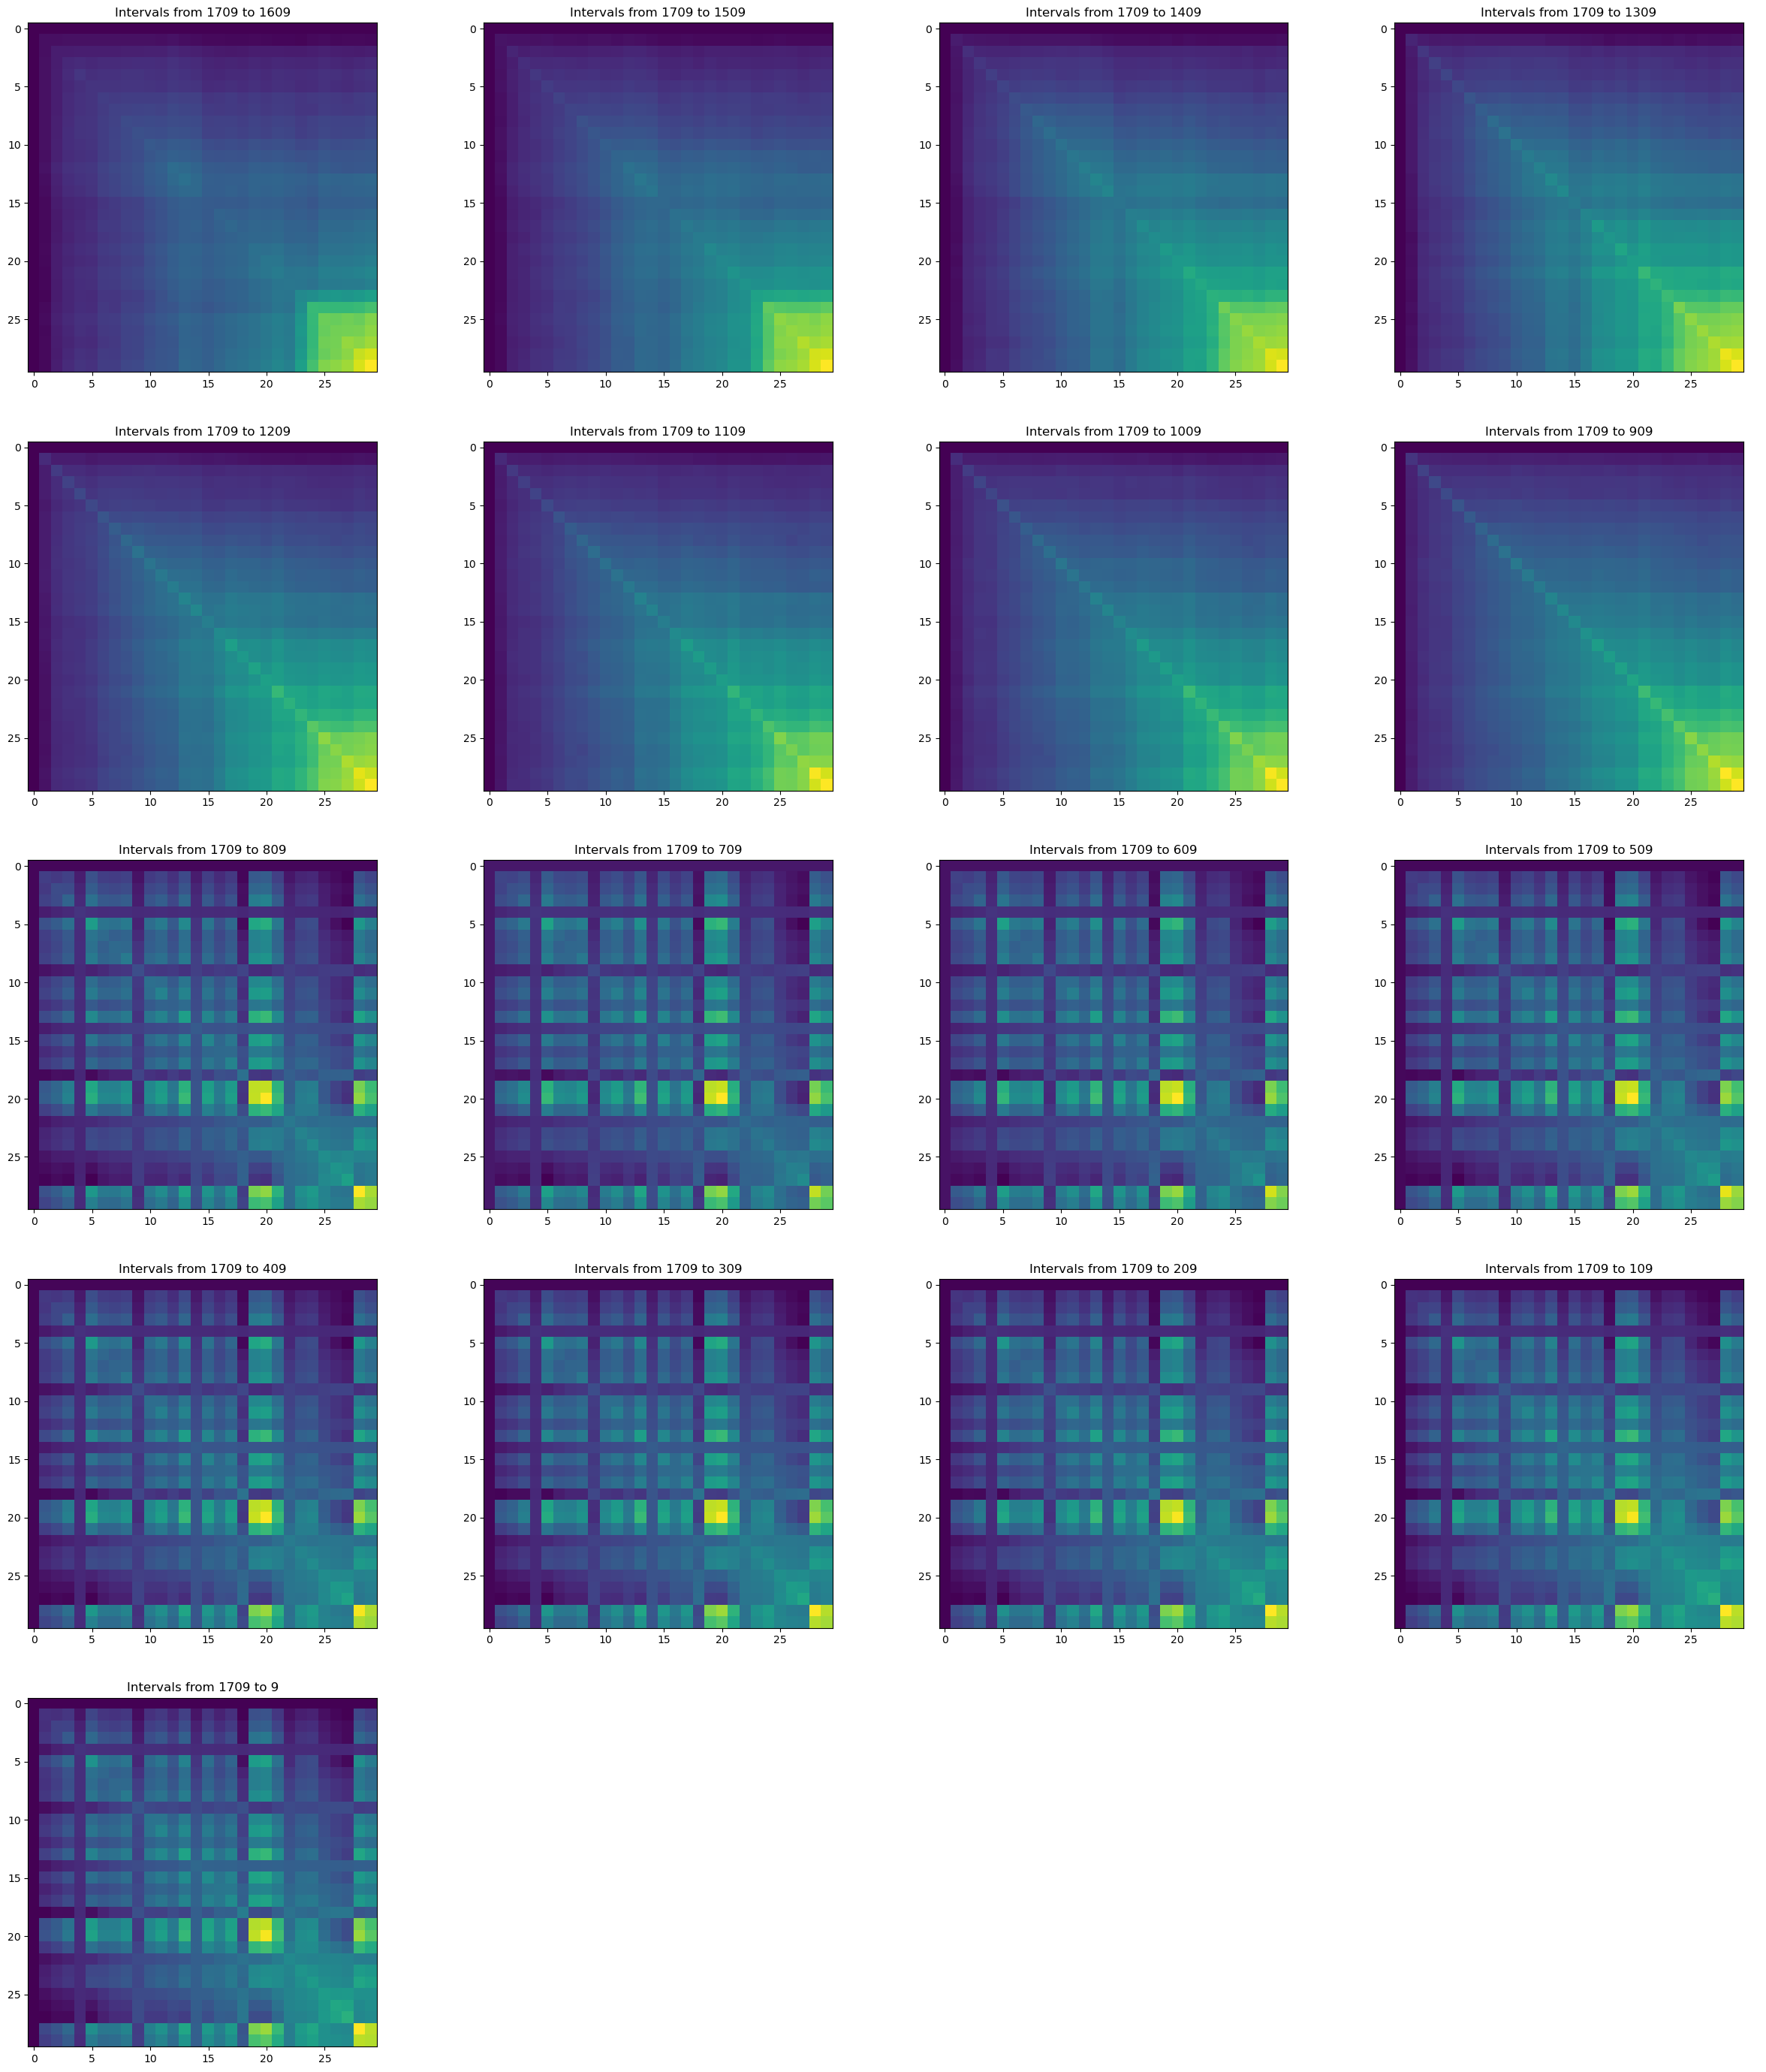

In [8]:
# Sequentially adding 100 rows for the computation of the covariance matrix - but in reverse order

fig, axes = plt.subplots(5, 4, figsize=(30,35))

reverse_polluteddata_arr = polluteddata_arr[::-1]

for i in range(100, len(reverse_polluteddata_arr), 100):

    covmat = np.cov(reverse_polluteddata_arr[:i], rowvar=False)

    ax = axes[ i//401, (i//101)%4 ]
    ax.imshow( covmat )
    ax.set_title(f"Intervals from 1709 to {1709-i}")

# Remove empty subplots
for i in range(17, len(axes.flat)):
    axes.flat[i].axis('off')

Now, we can see that the plots were quite regular when we had intervals from 1709 to 909
\
\
But as soon as we added the intervals from 809 to 909 - they became irregular
\
\
So by iterating in reverse we can say that the upper bound for $t_2$ is around 900 


### Verifying that the polluted data $[t_1, t_2]$ is between $[700, 900]$

We verify that the polluted data is between 700 and 900 by removing those intervals and then observing the covariance matrix plots again

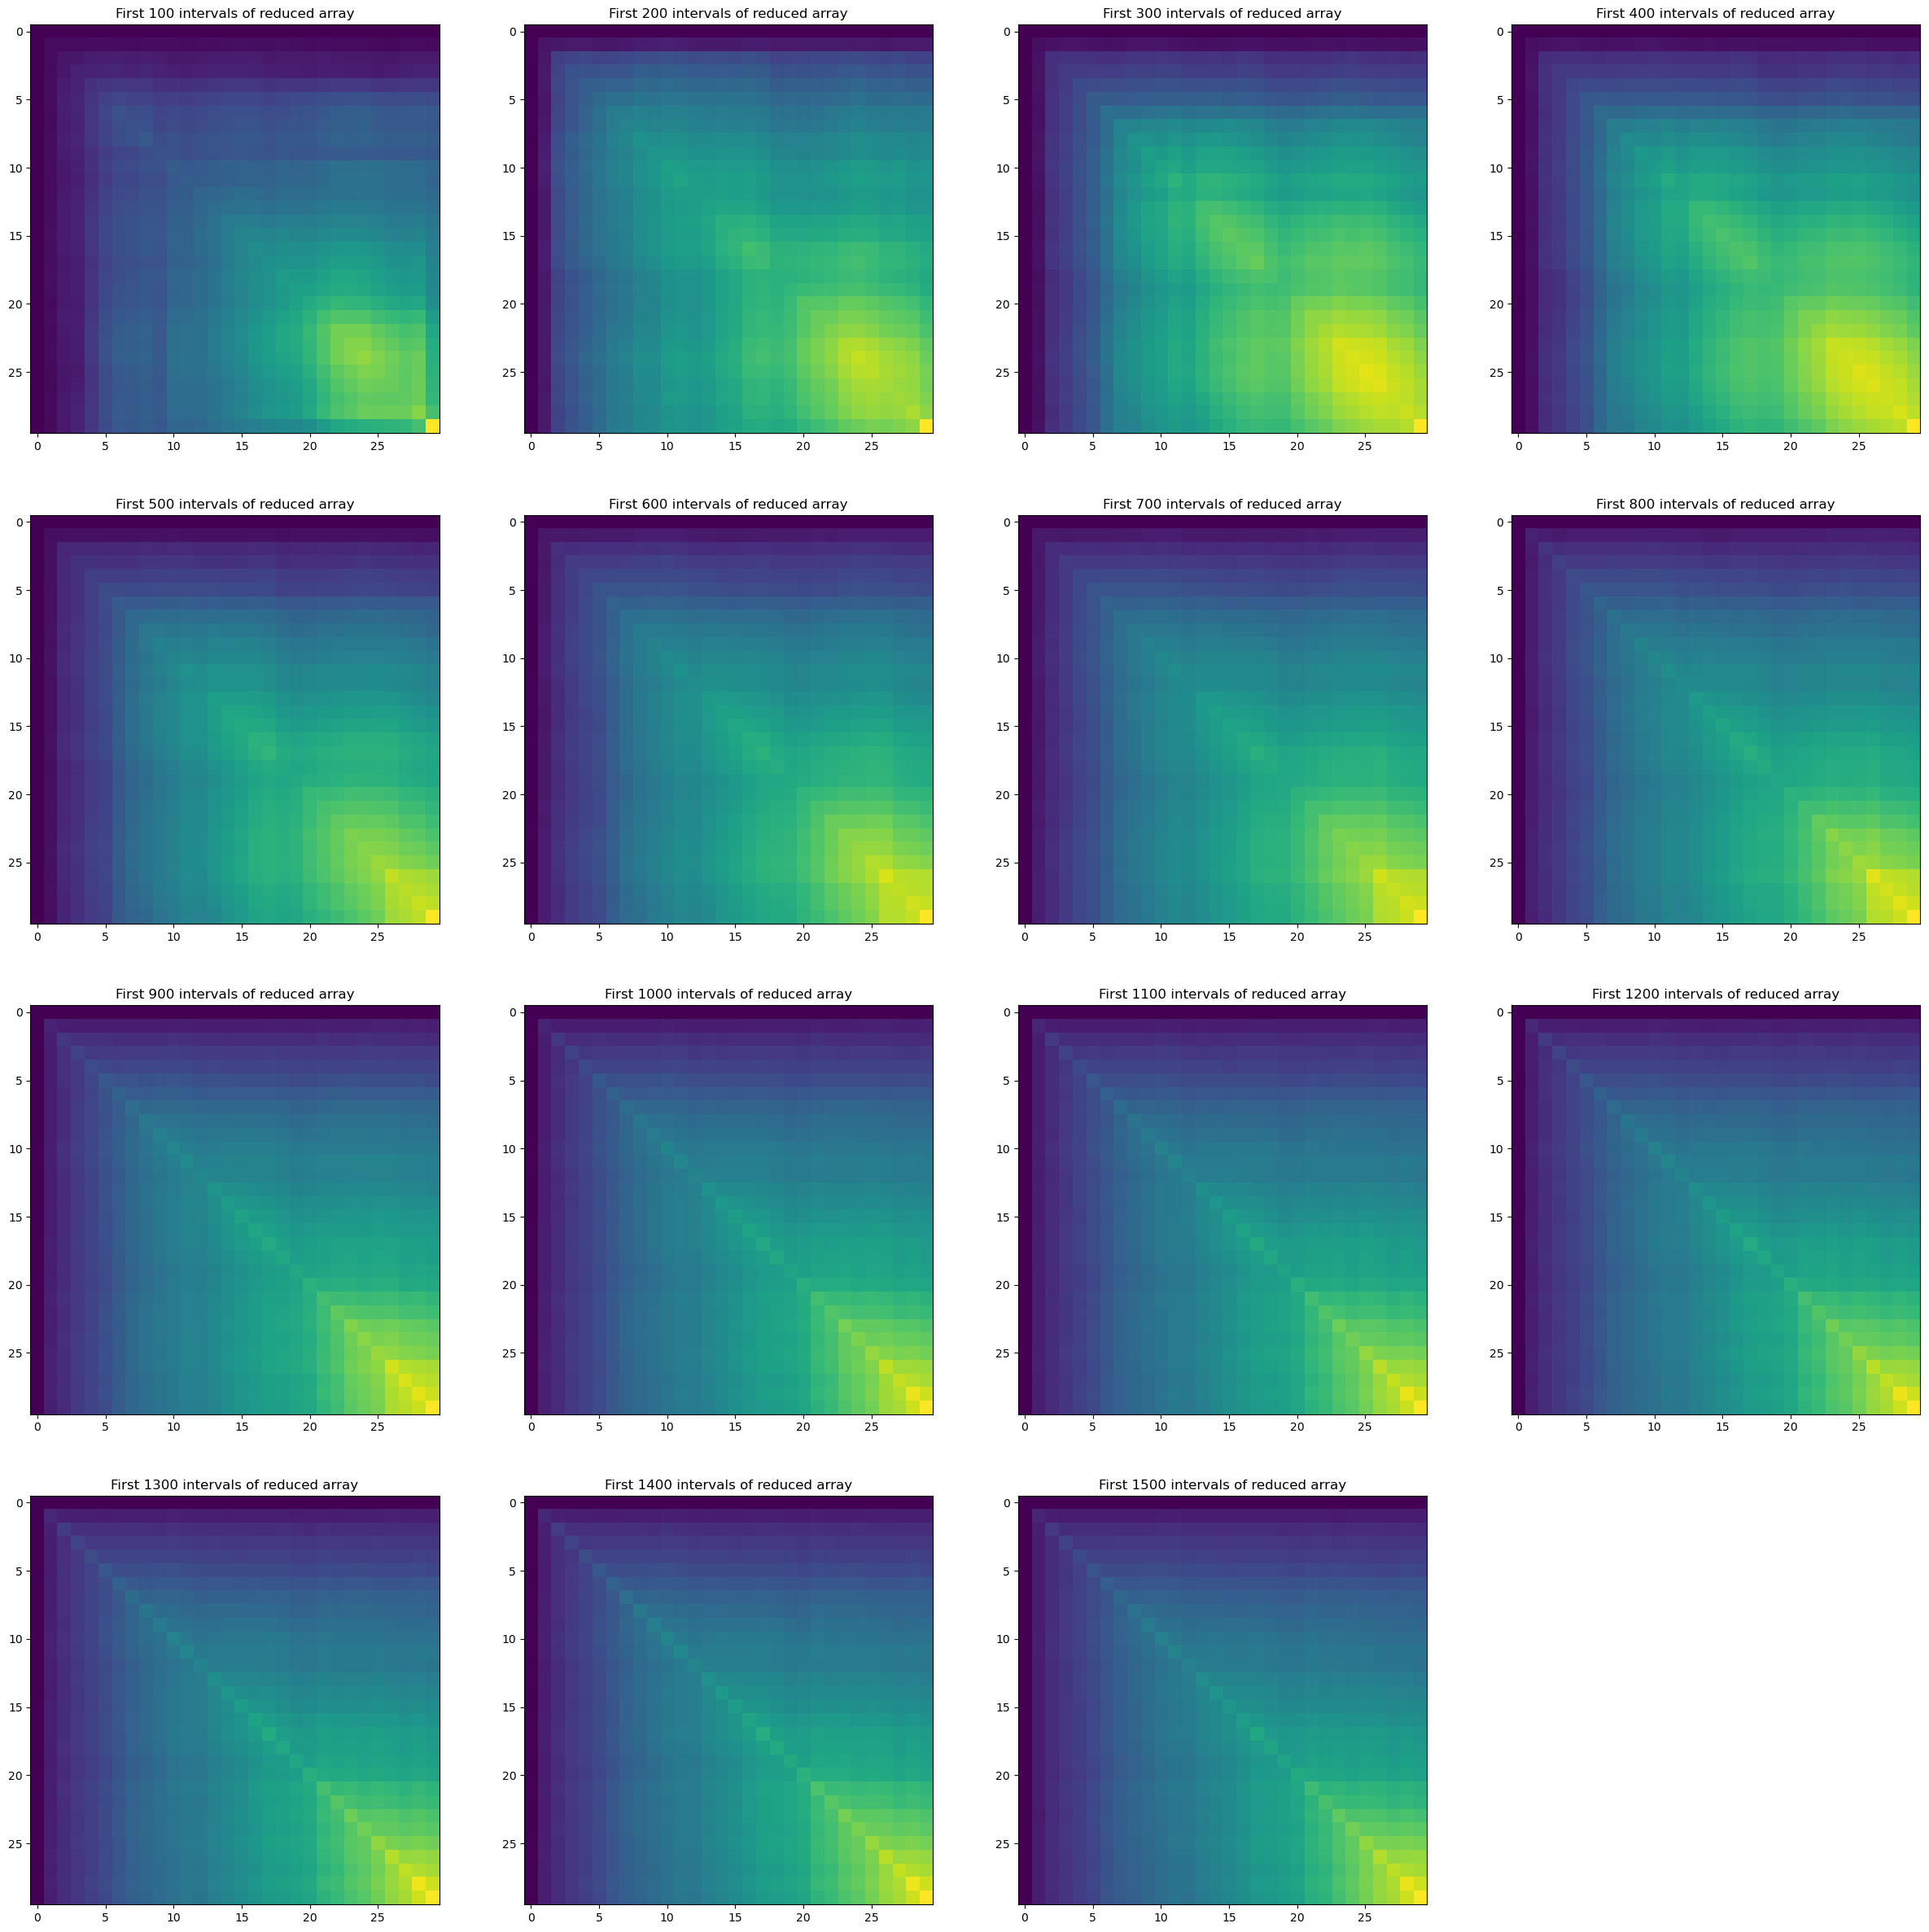

In [9]:
# Sequentially computing the covariance matrices again, but for a reduced polluteddata array
# We remove the intervals from 700 to 900

fig, axes = plt.subplots(4, 4, figsize=(30,30))

reduced_polluteddata_arr = np.delete(polluteddata_arr, np.arange(700,900), axis=0)

for i in range(100, len(reduced_polluteddata_arr), 100):

    covmat = np.cov(reduced_polluteddata_arr[:i], rowvar=False)

    ax = axes[ i//401, (i//101)%4 ]
    ax.imshow(covmat)
    ax.set_title(f"First {i} intervals of reduced array")


# Remove empty subplots
for i in range(15, len(axes.flat)):
    axes.flat[i].axis('off')

#### From the above plots we can verify that the polluted data is indeed between the intervals 700 to 900

#### So we conclude that:

#### $$ [t_1, t_2] \subseteq [700, 900] $$

### We can also plot the covariance matrix of all the half-hour intervals with each other as a heat-map

The "odd" square in the middle of the heat-map clearly indicated the noise that has been added in the intervals from $[700,900]$. Since, the noise has caused a drastic increase in the covariance of these intervals

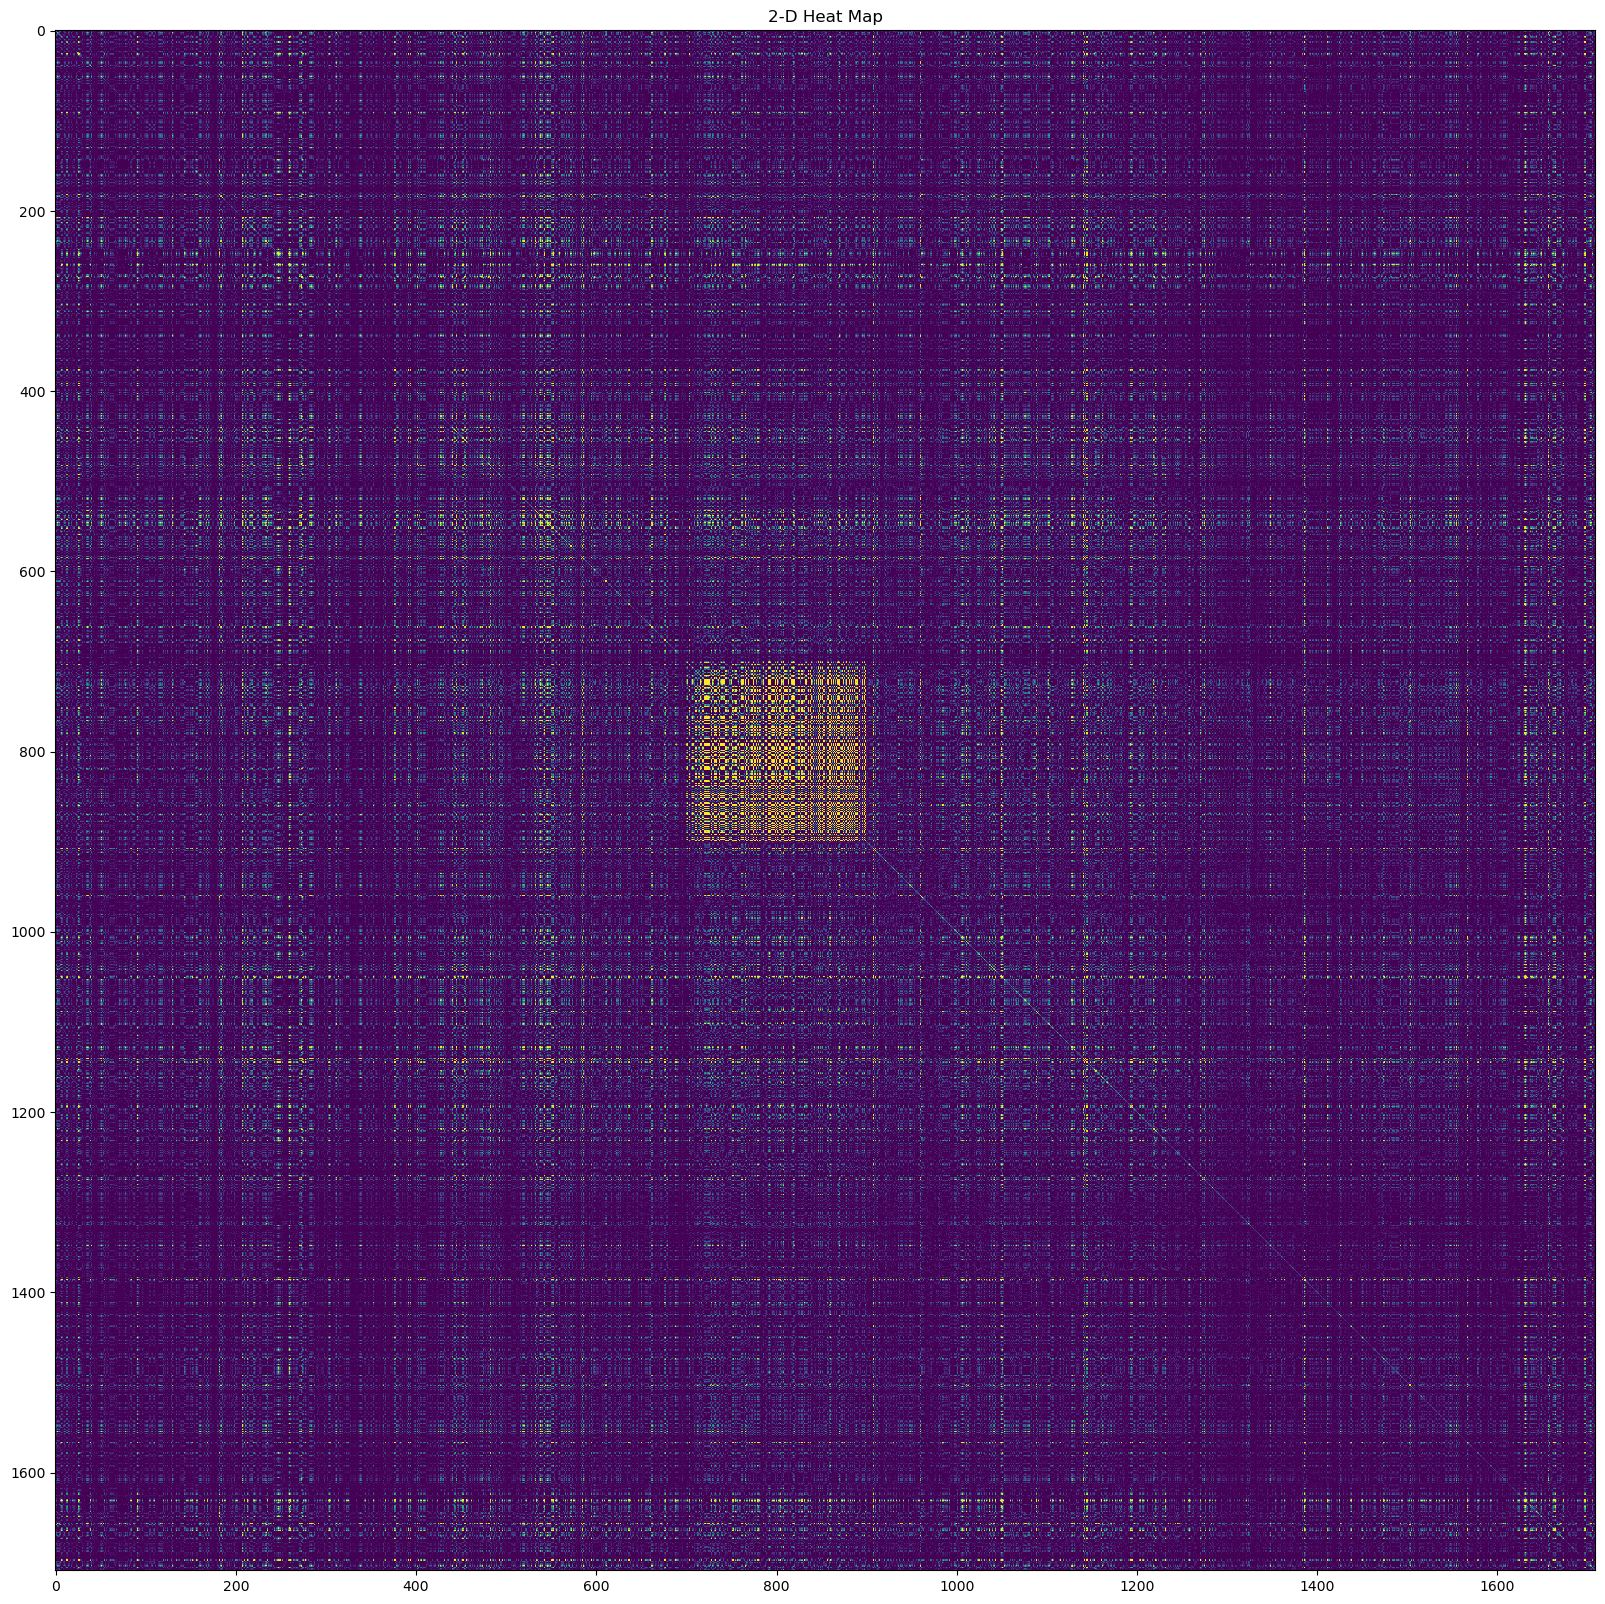

In [45]:
full_covariance_matrix = np.cov(polluteddata_arr.T, rowvar=False)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(full_covariance_matrix, vmin=0, vmax=50)
plt.title( "2-D Heat Map" )
plt.show()